# LSTM

## Problem 1 - Univariate Forecasting

In [2]:
!pip install --upgrade scalecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 61.5 MB/s eta 0:00:00
  Created wheel for scalecast: filename=SCALECAST-0.19.8-py3-none-any.whl size=125274 sha256=2e48f0638a358acd56d1dfd86c399c4af6606677992402387940280e0974a7b4
  Stored in directory: /root/.cache/pip/wheels/ac/67/2e/0244bcec7f41d76aae4c4196b64d31a20d474a7d5468f3d67e
Successfully built scalecast
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scalecast.Forecaster import Forecaster
from scalecast.Pipeline import Transformer, Reverter, Pipeline
from scalecast.util import (
    find_optimal_transformation,
    gen_rnn_grid,
    backtest_for_resid_matrix,
    get_backtest_resid_matrix,
    overwrite_forecast_intervals,
    infer_apply_Xvar_selection,
)
from scalecast import GridGenerator
from tensorflow.keras.callbacks import EarlyStopping
import pandas_datareader as pdr

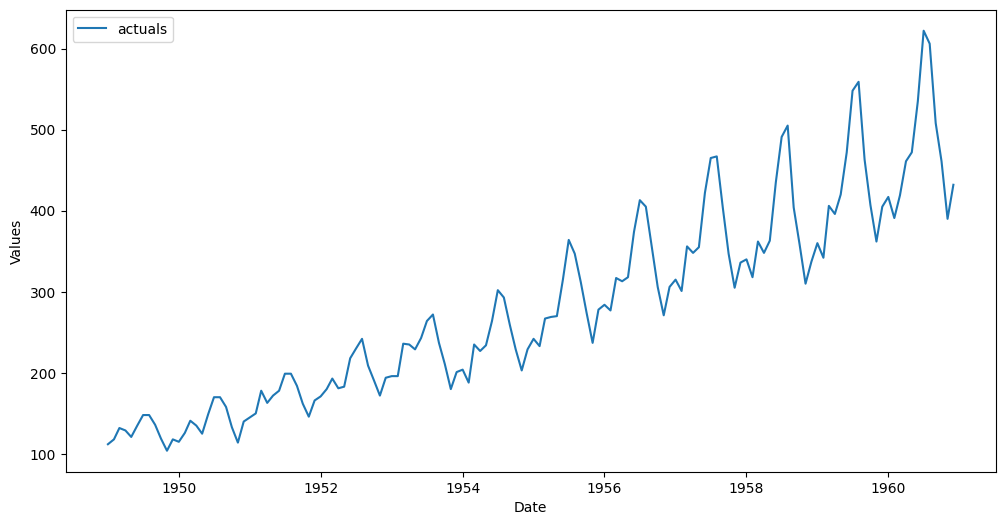

In [4]:
data = pd.read_csv('AirPassengers.csv',parse_dates=['Month'])

f = Forecaster(
    y=data['#Passengers'],
    current_dates=data['Month'],
    future_dates = 24,
)

f.plot()
plt.show()

In [5]:
def forecaster(f):
    f.set_estimator('rnn')
    f.manual_forecast(
        lags = 18,
        layers_struct = [
            ('LSTM',{'units':36,'activation':'tanh'}),
        ],
        epochs=200,
        call_me = 'lstm',
    )

transformer = Transformer(
    transformers = [
        ('DetrendTransform',{'poly_order':2}),
        'DeseasonTransform',
    ],
)

reverter = Reverter(
    reverters = [
        'DeseasonRevert',
        'DetrendRevert',
    ],
    base_transformer = transformer,
)

pipeline = Pipeline(
    steps = [
        ('Transform',transformer),
        ('Forecast',forecaster),
        ('Revert',reverter),
    ]
)

f = pipeline.fit_predict(f)

Epoch 1/200
4/4 [==============================] - 3s 18ms/step - loss: 0.3707
Epoch 2/200
4/4 [==============================] - 0s 7ms/step - loss: 0.3509
Epoch 3/200
4/4 [==============================] - 0s 7ms/step - loss: 0.3296
Epoch 4/200
4/4 [==============================] - 0s 9ms/step - loss: 0.3056
Epoch 5/200
4/4 [==============================] - 0s 7ms/step - loss: 0.2771
Epoch 6/200
4/4 [==============================] - 0s 7ms/step - loss: 0.2434
Epoch 7/200
4/4 [==============================] - 0s 7ms/step - loss: 0.2126
Epoch 8/200
4/4 [==============================] - 0s 7ms/step - loss: 0.1960
Epoch 9/200
4/4 [==============================] - 0s 7ms/step - loss: 0.1776
Epoch 10/200
4/4 [==============================] - 0s 7ms/step - loss: 0.1623
Epoch 11/200
4/4 [==============================] - 0s 7ms/step - loss: 0.1541
Epoch 12/200
4/4 [==============================] - 0s 9ms/step - loss: 0.1486
Epoch 13/200
4/4 [==============================] - 0s 7ms/s

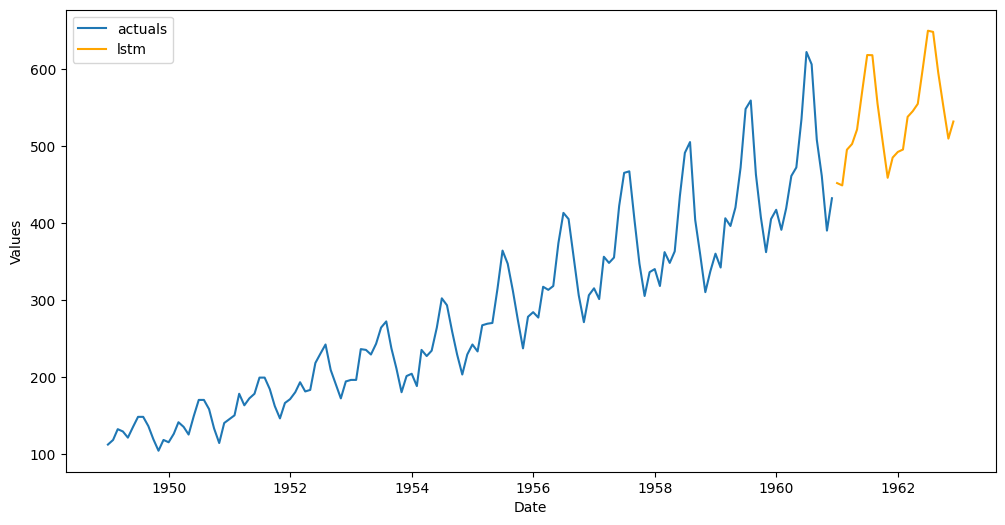

In [6]:
f.plot()
plt.savefig('LSTM Univariate.png')
plt.show()

## Problem 2 - Multivariate Forecasting

In [7]:
data = pd.read_csv('avocado.csv')

In [8]:
# demand
vol = data.groupby('Date')['Total Volume'].sum()
# price
price = data.groupby('Date')['AveragePrice'].sum()

fvol = Forecaster(
    y = vol,
    current_dates = vol.index,
    test_length = 13,
    validation_length = 13,
    future_dates = 13,
    metrics = ['rmse','r2'],
)
fprice = Forecaster(
    y = price,
    current_dates = price.index,
    future_dates = 13,
)

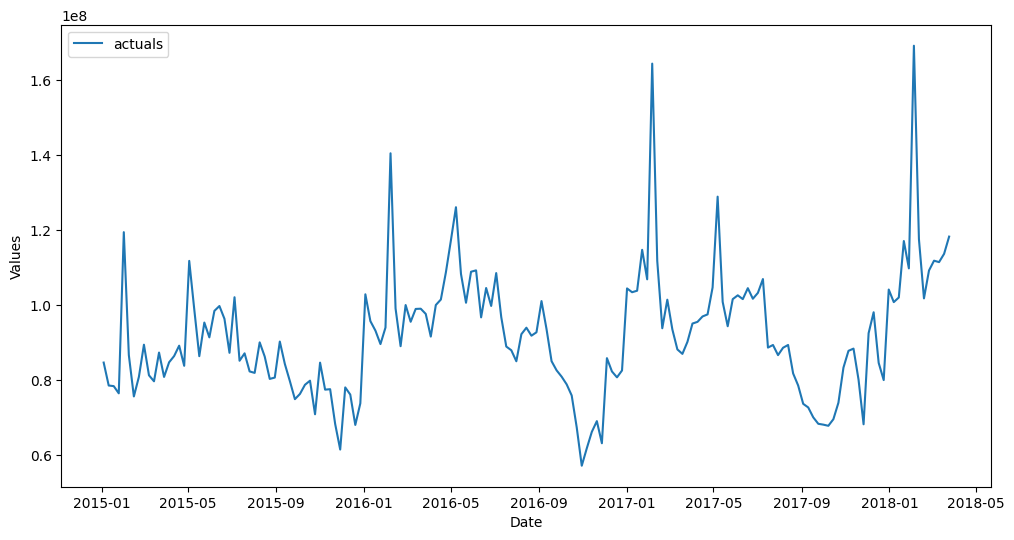

In [9]:
fvol.plot()
plt.show()

In [10]:
transformer, reverter = find_optimal_transformation(
    fvol,
    set_aside_test_set=True, # prevents leakage so we can benchmark the resulting models fairly
    return_train_only = True, # prevents leakage so we can benchmark the resulting models fairly
    verbose=True,
    detrend_kwargs=[
        {'loess':True},
        {'poly_order':1},
        {'ln_trend':True},
    ],
    m = 52, # what makes one seasonal cycle?
    test_length = 4,
)

Using mlr model to find the best transformation set on 1 test sets, each 4 in length.
All transformation tries will be evaluated with 52 lags.
Last transformer tried:
[]
Score (rmse): 10788435.478499787
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'loess': True})]
Score (rmse): 17367936.069693502
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'poly_order': 1})]
Score (rmse): 12269036.469923073
--------------------------------------------------
Last transformer tried:
[('DetrendTransform', {'ln_trend': True})]
Score (rmse): 12093617.597284073
--------------------------------------------------
Last transformer tried:
[('DeseasonTransform', {'m': 52, 'model': 'add'})]
Score (rmse): 9289548.042079167
--------------------------------------------------
Last transformer tried:
[('DeseasonTransform', {'m': 52, 'model': 'add'}), ('Transform', BoxcoxTransform, {'lmbda': -0.5})]
Score (rmse): 1

In [11]:
fprice = transformer.fit_transform(fprice)
fvol = transformer.fit_transform(fvol)

In [12]:
rnn_grid = gen_rnn_grid(
    layer_tries = 10,
    min_layer_size = 3,
    max_layer_size = 5,
    units_pool = [100],
    epochs = [100],
    dropout_pool = [0,0.05],
    validation_split=.2,
    callbacks=EarlyStopping(
      monitor='val_loss',
      patience=3,
    ),
    random_seed = 20,
) # creates a grid of hyperparameter values to tune the LSTM model

In [13]:
def forecaster(fvol,fprice):
    # naive forecast for benchmarking
    fvol.set_estimator('naive')
    fvol.manual_forecast()
    # univariate lstm model
    fvol.add_ar_terms(13) # the model will use 13 series lags
    fvol.set_estimator('rnn')
    fvol.ingest_grid(rnn_grid)
    fvol.tune()
    fvol.auto_forecast(call_me='lstm_univariate')
    # multivariate lstm model
    fvol.add_series(fprice.y,called='price')
    fvol.add_lagged_terms('price',lags=13,drop=True)
    fvol.ingest_grid(rnn_grid)
    fvol.tune()
    fvol.auto_forecast(call_me='lstm_multivariate')

In [14]:
forecaster(fvol=fvol,fprice=fprice)

1/1 [==============================] - 0s 398ms/step


1/1 [==============================] - 0s 177ms/step


1/1 [==============================] - 0s 405ms/step


1/1 [==============================] - 0s 178ms/step


1/1 [==============================] - 0s 490ms/step


1/1 [==============================] - 0s 402ms/step


1/1 [==============================] - 0s 392ms/step


1/1 [==============================] - 0s 174ms/step


1/1 [==============================] - 0s 386ms/step


1/1 [==============================] - 0s 413ms/step


1/1 [==============================] - 0s 430ms/step


1/1 [==============================] - 0s 180ms/step


1/1 [==============================] - 0s 388ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 410ms/step


1/1 [==============================] - 0s 402ms/step


1/1 [==============================] - 0s 405ms/step


1/1 [==============================] - 0s 179ms/step


1/1 [==============================] - 0s 407ms/step


1/1 [==============================] - 0s 390ms/step


5/5 [==============================] - 0s 6ms/step


In [15]:
fvol = reverter.fit_transform(fvol)

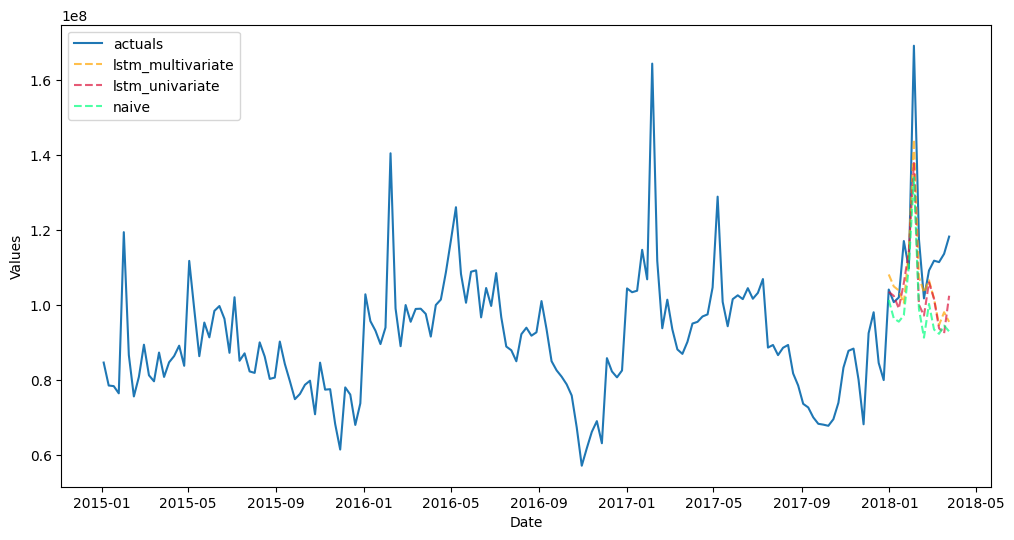

In [16]:
fvol.plot_test_set(order_by='TestSetRMSE')
plt.savefig('LSTM MV test results.png')
plt.show()

In [17]:
pd.options.display.float_format = '{:,.4f}'.format
summ = fvol.export('model_summaries',determine_best_by='TestSetRMSE')
summ[['ModelNickname','TestSetRMSE','TestSetR2']]

,ModelNickname,TestSetRMSE,TestSetR2
0,lstm_multivariate,"13,048,565.8720",0.4015
1,lstm_univariate,"14,100,278.5311",0.3012
2,naive,"17,403,456.6059",-0.0646


In [18]:
summ[['ModelNickname','HyperParams']].style.set_properties(height = 5)

,ModelNickname,HyperParams
0,lstm_multivariate,"{'verbose': 0, 'epochs': 100, 'validation_split': 0.2, 'callbacks': , 'layers_struct': [('LSTM', {'units': 100, 'activation': 'tanh', 'dropout': 0.0, 'return_sequences': False}, 'LSTM', {'units': 100, 'activation': 'tanh', 'dropout': 0.0}, 'LSTM', {'units': 100, 'activation': 'tanh', 'dropout': 0.0})]}"
1,lstm_univariate,"{'verbose': 0, 'epochs': 100, 'validation_split': 0.2, 'callbacks': , 'layers_struct': [('LSTM', {'units': 100, 'activation': 'tanh', 'dropout': 0.0, 'return_sequences': False}, 'LSTM', {'units': 100, 'activation': 'tanh', 'dropout': 0.0}, 'LSTM', {'units': 100, 'activation': 'tanh', 'dropout': 0.0}, 'LSTM', {'units': 100, 'activation': 'tanh', 'dropout': 0.0}, 'LSTM', {'units': 100, 'activation': 'tanh', 'dropout': 0.0})]}"
2,naive,{}


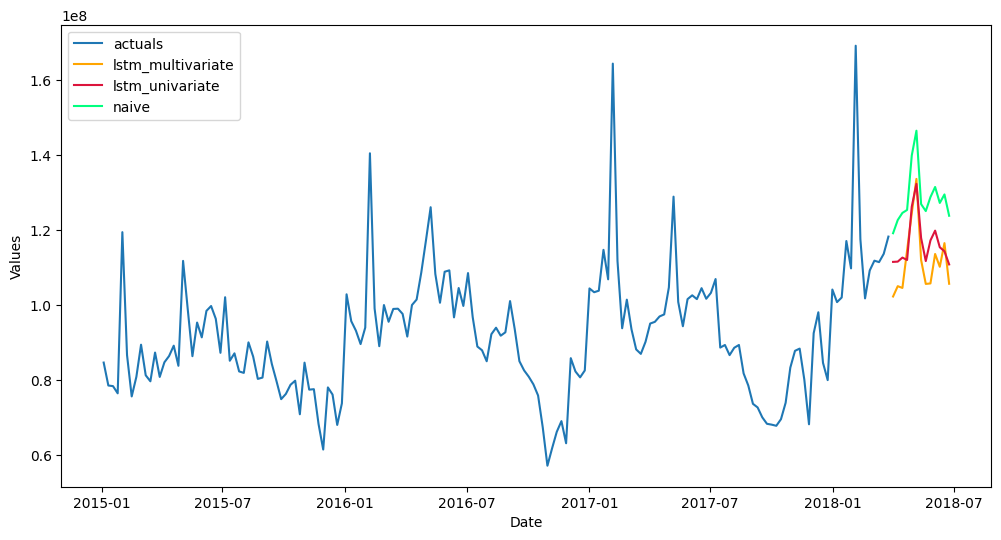

In [19]:
fvol.plot(order_by='TestSetRMSE')
plt.show()

## Problem 3 - Probabilistic Forecasting

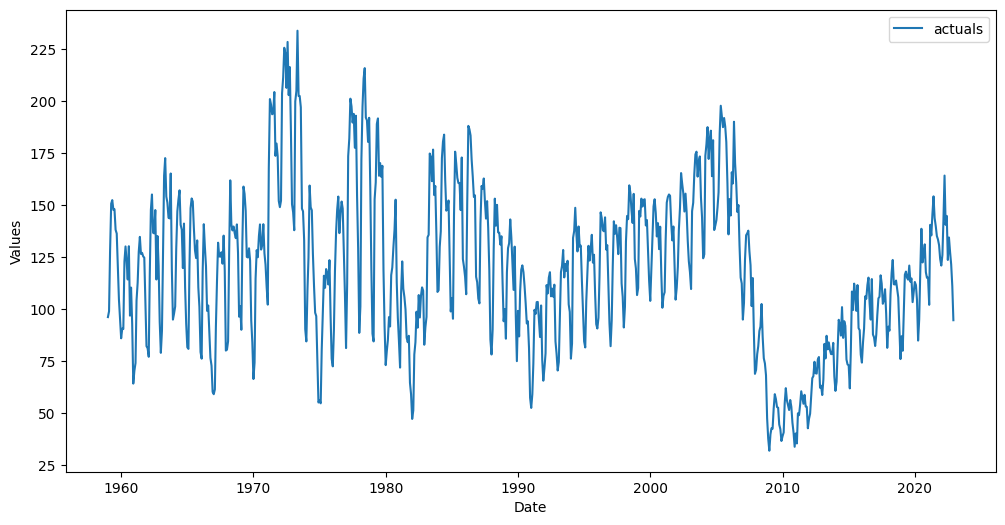

In [20]:
df = pdr.get_data_fred(
    'HOUSTNSA',
    start = '1959-01-01',
    end = '2022-12-31',
)

f = Forecaster(
    y = df['HOUSTNSA'],
    current_dates = df.index,
    future_dates = 24, # 2-year forecast horizon
    test_length = .1, # 10% test length
    cis = True,
    cilevel = .9, # 90% intervals
)

f.plot()
plt.show()

In [21]:
transformer, reverter = find_optimal_transformation(
    f,
    estimator = 'lstm',
    epochs = 10,
    set_aside_test_set=True, # prevents leakage so we can benchmark the resulting models fairly
    return_train_only = True, # prevents leakage so we can benchmark the resulting models fairly
    verbose=True,
    m = 52, # what makes one seasonal cycle?
    test_length = 24,
    num_test_sets = 3,
    space_between_sets = 12,
    detrend_kwargs=[
        {'loess':True},
        {'poly_order':1},
        {'ln_trend':True},
    ],
)

Using lstm model to find the best transformation set on 3 test sets, each 24 in length.
Epoch 1/10
17/17 [==============================] - 2s 6ms/step - loss: 0.4252
Epoch 2/10
17/17 [==============================] - 0s 5ms/step - loss: 0.4027
Epoch 3/10
17/17 [==============================] - 0s 5ms/step - loss: 0.3777
Epoch 4/10
17/17 [==============================] - 0s 5ms/step - loss: 0.3496
Epoch 5/10
17/17 [==============================] - 0s 5ms/step - loss: 0.3180
Epoch 6/10
17/17 [==============================] - 0s 6ms/step - loss: 0.2839
Epoch 7/10
17/17 [==============================] - 0s 6ms/step - loss: 0.2496
Epoch 8/10
17/17 [==============================] - 0s 6ms/step - loss: 0.2182
Epoch 9/10
17/17 [==============================] - 0s 6ms/step - loss: 0.1932
Epoch 10/10
1/1 [==============================] - 0s 425ms/step
Epoch 1/10
21/21 [==============================] - 3s 6ms/step - loss: 0.4287
Epoch 2/10
21/21 [==============================] - 0s 5m

17/17 [==============================] - 2s 5ms/step - loss: 0.8776
Epoch 2/10
17/17 [==============================] - 0s 5ms/step - loss: 0.8492
Epoch 3/10
17/17 [==============================] - 0s 6ms/step - loss: 0.8187
Epoch 4/10
17/17 [==============================] - 0s 5ms/step - loss: 0.7838
Epoch 5/10
17/17 [==============================] - 0s 8ms/step - loss: 0.7425
Epoch 6/10
17/17 [==============================] - 0s 9ms/step - loss: 0.6936
Epoch 7/10
17/17 [==============================] - 0s 8ms/step - loss: 0.6361
Epoch 8/10
17/17 [==============================] - 0s 8ms/step - loss: 0.5691
Epoch 9/10
17/17 [==============================] - 0s 8ms/step - loss: 0.4925
Epoch 10/10
17/17 [==============================] - 0s 8ms/step - loss: 0.4062


1/1 [==============================] - 0s 455ms/step
Epoch 1/10
17/17 [==============================] - 2s 5ms/step - loss: nan
Epoch 2/10
17/17 [==============================] - 0s 5ms/step - loss: nan
Epoch 3/10
17/17 [==============================] - 0s 6ms/step - loss: nan
Epoch 4/10
17/17 [==============================] - 0s 5ms/step - loss: nan
Epoch 5/10
17/17 [==============================] - 0s 5ms/step - loss: nan
Epoch 6/10
17/17 [==============================] - 0s 6ms/step - loss: nan
Epoch 7/10
17/17 [==============================] - 0s 6ms/step - loss: nan
Epoch 8/10
17/17 [==============================] - 0s 5ms/step - loss: nan
Epoch 9/10
17/17 [==============================] - 0s 5ms/step - loss: nan
Epoch 10/10
1/1 [==============================] - 0s 395ms/step
Epoch 1/10


17/17 [==============================] - 4s 6ms/step - loss: 0.2929
Epoch 2/10
17/17 [==============================] - 0s 5ms/step - loss: 0.2912
Epoch 3/10
17/17 [==============================] - 0s 6ms/step - loss: 0.2901
Epoch 4/10
17/17 [==============================] - 0s 6ms/step - loss: 0.2889
Epoch 5/10
17/17 [==============================] - 0s 9ms/step - loss: 0.2875
Epoch 6/10
17/17 [==============================] - 0s 8ms/step - loss: 0.2861
Epoch 7/10
17/17 [==============================] - 0s 9ms/step - loss: 0.2845
Epoch 8/10
17/17 [==============================] - 0s 8ms/step - loss: 0.2828
Epoch 9/10
17/17 [==============================] - 0s 9ms/step - loss: 0.2811
Epoch 10/10
17/17 [==============================] - 0s 8ms/step - loss: 0.2793


1/1 [==============================] - 1s 509ms/step
Epoch 1/10
17/17 [==============================] - 2s 5ms/step - loss: 0.4317
Epoch 2/10
17/17 [==============================] - 0s 5ms/step - loss: 0.4098
Epoch 3/10
17/17 [==============================] - 0s 6ms/step - loss: 0.3865
Epoch 4/10
17/17 [==============================] - 0s 6ms/step - loss: 0.3597
Epoch 5/10
17/17 [==============================] - 0s 6ms/step - loss: 0.3286
Epoch 6/10
17/17 [==============================] - 0s 5ms/step - loss: 0.2928
Epoch 7/10
17/17 [==============================] - 0s 6ms/step - loss: 0.2531
Epoch 8/10
17/17 [==============================] - 0s 5ms/step - loss: 0.2124
Epoch 9/10
17/17 [==============================] - 0s 6ms/step - loss: 0.1753
Epoch 10/10
1/1 [==============================] - 0s 396ms/step
Epoch 1/10
21/21 [==============================] - 2s 6ms/step - loss: 0.4171
Epoch 2/10
21/21 [==============================] - 0s 5ms/step - loss: 0.3872
Epoch 3/10
21

[2.       +0.76939352j 0.6041041+0.j         2.       +0.47174114j
 2.       +0.38425338j 2.       +0.36643846j 2.       +0.32157075j
 2.       +0.25574003j 2.       +0.23821694j 2.       +0.23407927j
 2.       +0.23720561j 2.       +0.25231215j 2.       +0.25671722j
 2.       +0.28451948j 2.       +0.30311645j 2.       +0.28115415j
 2.       +0.27979419j 2.       +0.27997099j 2.       +0.25794595j
 2.       +0.25035621j 2.       +0.23148404j 2.       +0.23928882j
 2.       +0.24236751j 2.       +0.26787107j 2.       +0.28522808j
 2.       +0.297192j   2.       +0.27788564j 2.       +0.27937115j
 2.       +0.30477776j 2.       +0.28868182j 2.       +0.26220031j
 2.       +0.24705343j 2.       +0.23220349j 2.       +0.24113911j
 2.       +0.23215691j 2.       +0.25094717j 2.       +0.25034242j
 2.       +0.26710701j 2.       +0.27452493j 2.       +0.26555741j
 2.       +0.26009729j 2.       +0.28411935j 2.       +0.26448164j
 2.       +0.26426433j 2.       +0.24808362j 2.       +0.26052

Last transformer tried:
[('DetrendTransform', {'poly_order': 1}), ('DeseasonTransform', {'m': 52, 'model': 'add'}), ('RobustScaleTransform',)]
Score (rmse): 14.252380043525404
--------------------------------------------------
Final Selection:
[('DetrendTransform', {'poly_order': 1, 'train_only': True}), ('DeseasonTransform', {'m': 52, 'model': 'add', 'train_only': True}), ('ScaleTransform', {'train_only': True})]


[-2.        +5.19890005j  0.8655432 +0.j         -2.        +8.47922658j
 -2.       +10.40979792j -2.       +10.91588464j -2.       +12.43894243j
 -2.       +15.64088373j -2.       +16.79141689j -2.       +17.08822808j
 -2.       +16.86300774j -2.       +15.85337849j -2.       +15.58134675j
 -2.       +14.05879116j -2.       +13.19624832j -2.       +14.227071j
 -2.       +14.29622241j -2.       +14.28719453j -2.       +15.50712447j
 -2.       +15.97723485j -2.       +17.27980893j -2.       +16.71620118j
 -2.       +16.50386247j -2.       +14.93255715j -2.       +14.02386458j
 -2.       +13.45931232j -2.       +14.39441038j -2.       +14.31787074j
 -2.       +13.12431733j -2.       +13.85608542j -2.       +15.25551229j
 -2.       +16.19082961j -2.       +17.22626989j -2.       +16.58793564j
 -2.       +17.22972613j -2.       +15.93960986j -2.       +15.97811517j
 -2.       +14.97527134j -2.       +14.57062587j -2.       +15.06265644j
 -2.       +15.37886102j -2.       +14.07859053j -2. 

In [22]:
rnn_grid = gen_rnn_grid(
    layer_tries = 100,
    min_layer_size = 1,
    max_layer_size = 5,
    units_pool = [100],
    epochs = [100],
    dropout_pool = [0,0.05],
    validation_split=.2,
    callbacks=EarlyStopping(
      monitor='val_loss',
      patience=3,
    ),
    random_seed = 20,
) # make a really big grid and limit it manually

In [23]:
def forecaster(f,grid):
    f.auto_Xvar_select(
        try_trend=False,
        try_seasonalities=False,
        max_ar=100
    )
    f.set_estimator('rnn')
    f.ingest_grid(grid)
    f.limit_grid_size(10) # randomly reduce the big grid to 10
    f.cross_validate(k=3,test_length=24) # three-fold cross-validation
    f.auto_forecast()

In [24]:
pipeline = Pipeline(
    steps = [
        ('Transform',transformer),
        ('Forecast',forecaster),
        ('Revert',reverter),
    ]
)

f = pipeline.fit_predict(f,grid=rnn_grid)

1/1 [==============================] - 0s 414ms/step


1/1 [==============================] - 0s 185ms/step


1/1 [==============================] - 0s 397ms/step


1/1 [==============================] - 0s 176ms/step


1/1 [==============================] - 0s 174ms/step


1/1 [==============================] - 0s 389ms/step


1/1 [==============================] - 0s 405ms/step


1/1 [==============================] - 1s 601ms/step


1/1 [==============================] - 0s 182ms/step


1/1 [==============================] - 1s 596ms/step


1/1 [==============================] - 0s 417ms/step


1/1 [==============================] - 0s 178ms/step


1/1 [==============================] - 0s 410ms/step


1/1 [==============================] - 0s 172ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 422ms/step


1/1 [==============================] - 0s 404ms/step


1/1 [==============================] - 0s 396ms/step


1/1 [==============================] - 0s 180ms/step


1/1 [==============================] - 0s 408ms/step


1/1 [==============================] - 0s 402ms/step


1/1 [==============================] - 0s 185ms/step


1/1 [==============================] - 1s 554ms/step


1/1 [==============================] - 0s 173ms/step


1/1 [==============================] - 0s 178ms/step


1/1 [==============================] - 0s 419ms/step


1/1 [==============================] - 0s 417ms/step


1/1 [==============================] - 0s 389ms/step


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 0s 421ms/step


1/1 [==============================] - 0s 179ms/step


23/23 [==============================] - 0s 6ms/step


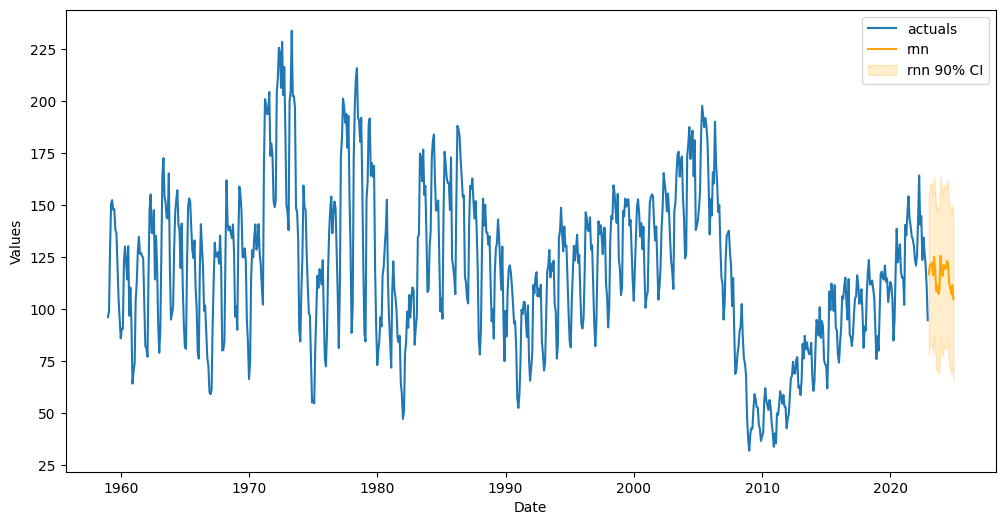

In [25]:
f.plot(ci=True)
plt.savefig('Probabilistic LSTM.png')
plt.show()

## Problem 4 - Dynamic Probabilistic Forecasting

In [26]:
params = f.best_params
num_chosen_lags = len(f.get_regressor_names())

In [27]:
def forecaster(f,params):
    f.set_estimator('rnn')
    f.manual_forecast(**params,test_again=False,lags=num_chosen_lags)

In [28]:
pipeline = Pipeline(
    steps = [
        ('Transform',transformer),
        ('Forecast',forecaster),
        ('Revert',reverter),
    ]
)

In [29]:
f = pipeline.fit_predict(f,params = params)

23/23 [==============================] - 0s 4ms/step


In [31]:
backtest_results = backtest_for_resid_matrix(
    f,
    pipeline=pipeline,
    alpha = .1,
    jump_back = 12,
    params = f.best_params,
)

23/23 [==============================] - 0s 7ms/step


22/22 [==============================] - 0s 4ms/step


22/22 [==============================] - 0s 4ms/step


22/22 [==============================] - 0s 4ms/step


21/21 [==============================] - 0s 5ms/step


21/21 [==============================] - 0s 4ms/step


20/20 [==============================] - 0s 5ms/step


20/20 [==============================] - 0s 4ms/step


20/20 [==============================] - 0s 4ms/step


19/19 [==============================] - 0s 4ms/step


In [32]:
backtest_resid_matrix = get_backtest_resid_matrix(backtest_results)

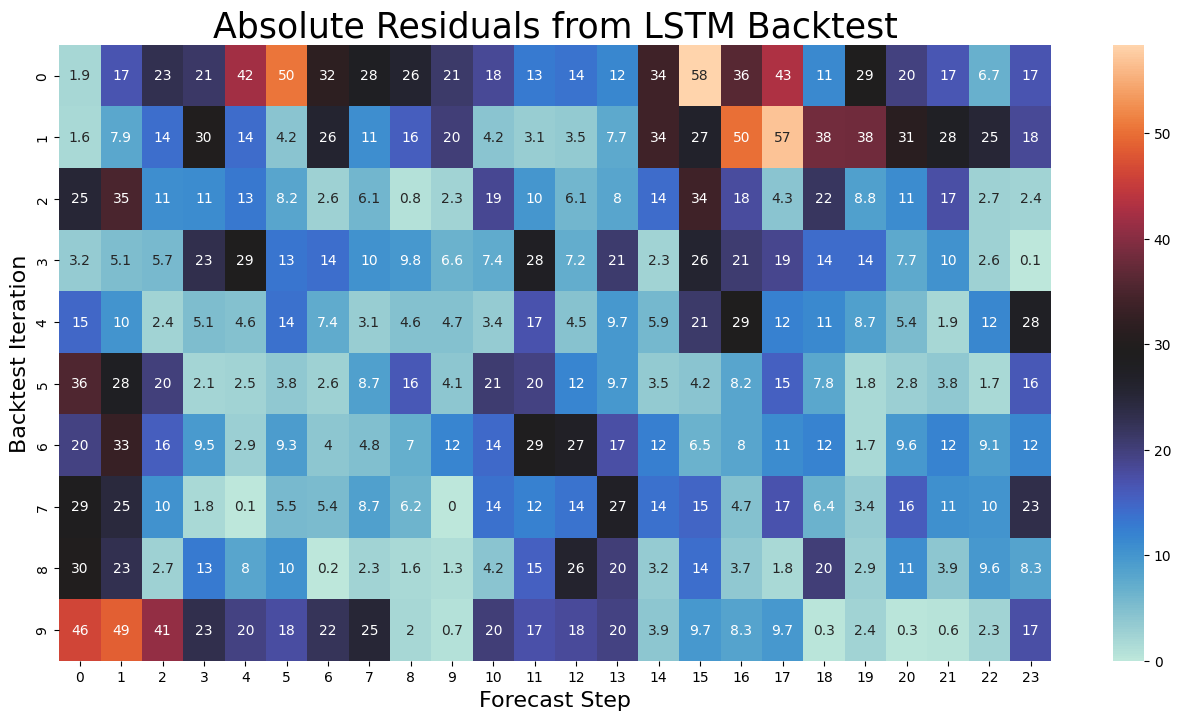

In [33]:
pd.options.display.max_columns = None
fig, ax = plt.subplots(figsize=(16,8))
mat = pd.DataFrame(np.abs(backtest_resid_matrix[0]['rnn']))
sns.heatmap(
    mat.round(1),
    annot = True,
    ax = ax,
    cmap = sns.color_palette("icefire", as_cmap=True),
)
plt.ylabel('Backtest Iteration',size=16)
plt.xlabel('Forecast Step',size = 16)
plt.title('Absolute Residuals from LSTM Backtest',size=25)
plt.savefig('LSTM Resid Matrix.png')
plt.show()

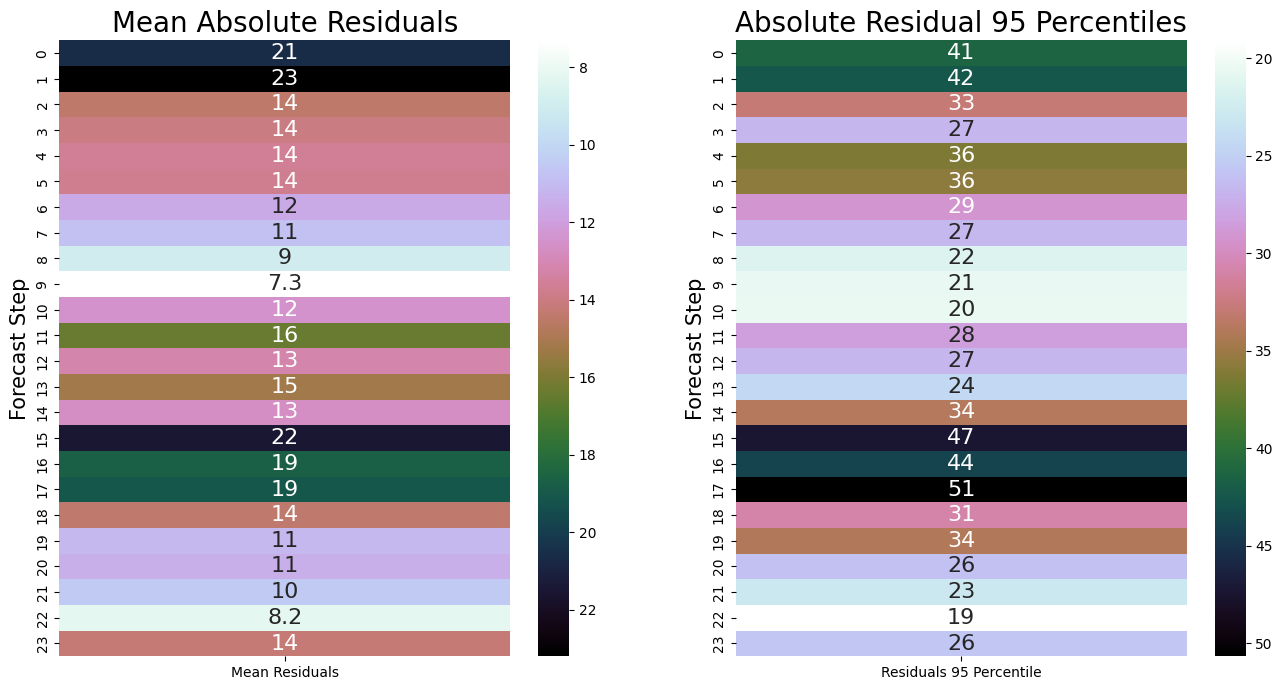

In [34]:
fig, ax = plt.subplots(1,2,figsize=(16,8))
sns.heatmap(
    pd.DataFrame({'Mean Residuals':mat.mean().round(1)}),
    annot = True,
    cmap = 'cubehelix_r',
    ax = ax[0],
    annot_kws={"fontsize": 16},
)
cbar = ax[0].collections[0].colorbar
cbar.ax.invert_yaxis()
ax[0].set_title('Mean Absolute Residuals',size=20)
ax[0].set_ylabel('Forecast Step',size=15)
ax[0].set_xlabel('')
sns.heatmap(
    pd.DataFrame({'Residuals 95 Percentile':np.percentile(mat, q=95, axis = 0)}),
    annot = True,
    cmap = 'cubehelix_r',
    ax = ax[1],
    annot_kws={"fontsize": 16},
)
cbar = ax[1].collections[0].colorbar
cbar.ax.invert_yaxis()
ax[1].set_title('Absolute Residual 95 Percentiles',size=20)
ax[1].set_ylabel('Forecast Step',size=15)
ax[1].set_xlabel('')
plt.show()

In [35]:
overwrite_forecast_intervals(f,backtest_resid_matrix=backtest_resid_matrix,alpha=.1)

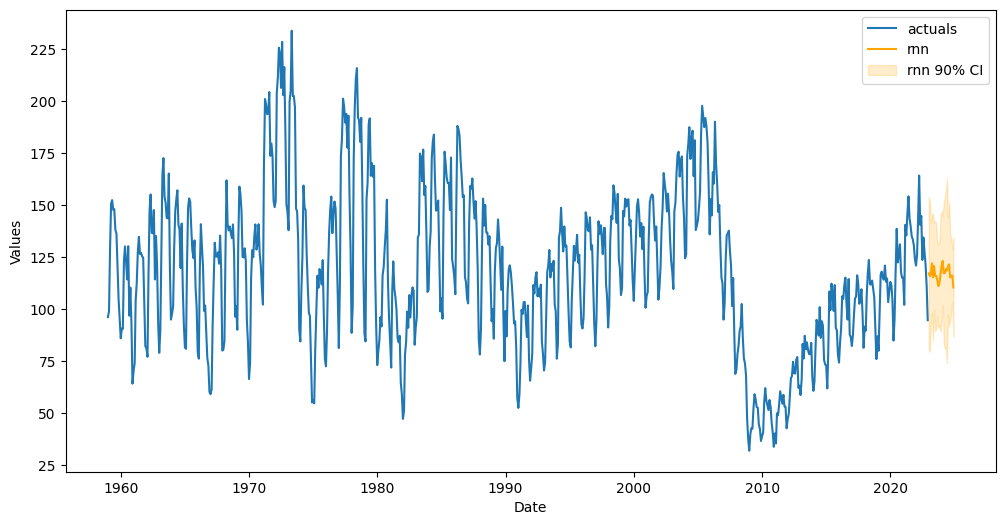

In [36]:
f.plot(ci=True)
plt.savefig('LSTM dynamic intervals.png')
plt.show()

## Problem 5 - Transfer Learning

### Scenario 1: New data from the same series

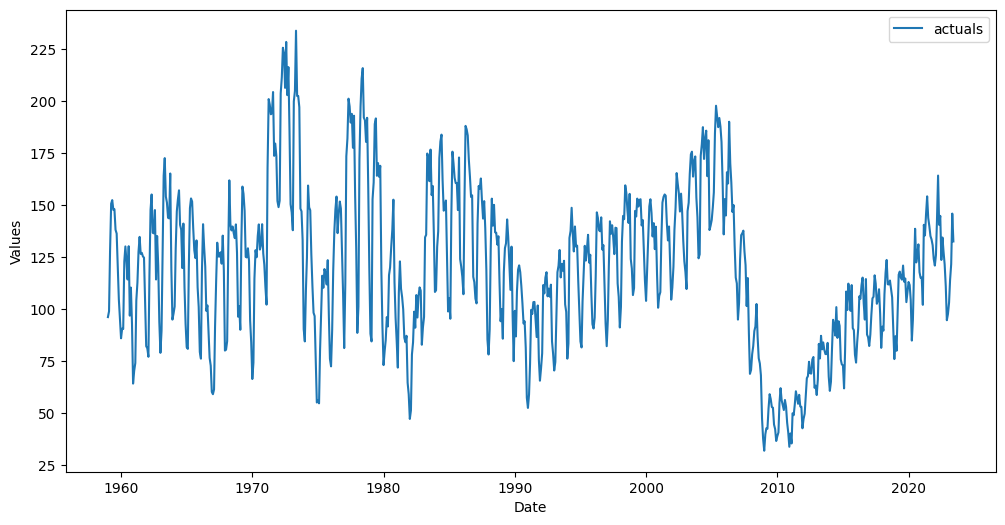

In [37]:
df = pdr.get_data_fred(
    'HOUSTNSA',
    start = '1959-01-01',
    end = '2023-06-30',
)

f_new = Forecaster(
    y = df.iloc[:,0],
    current_dates = df.index,
    future_dates = 24, # 2-year forecast horizon
)

f_new.plot()
plt.show()

In [38]:
def transfer_forecast(f_new,transfer_from):
    f_new = infer_apply_Xvar_selection(
        infer_from=transfer_from,
        apply_to=f_new
    )
    f_new.transfer_predict(
        transfer_from=transfer_from,
        model='rnn',
        model_type='tf'
    )

In [39]:
pipeline_can = Pipeline(
    steps = [
        ('Transform',transformer),
        ('Transfer Forecast',transfer_forecast),
        ('Revert',reverter),
    ]
)

f_new = pipeline_can.fit_predict(f_new,transfer_from=f)

24/24 [==============================] - 0s 13ms/step


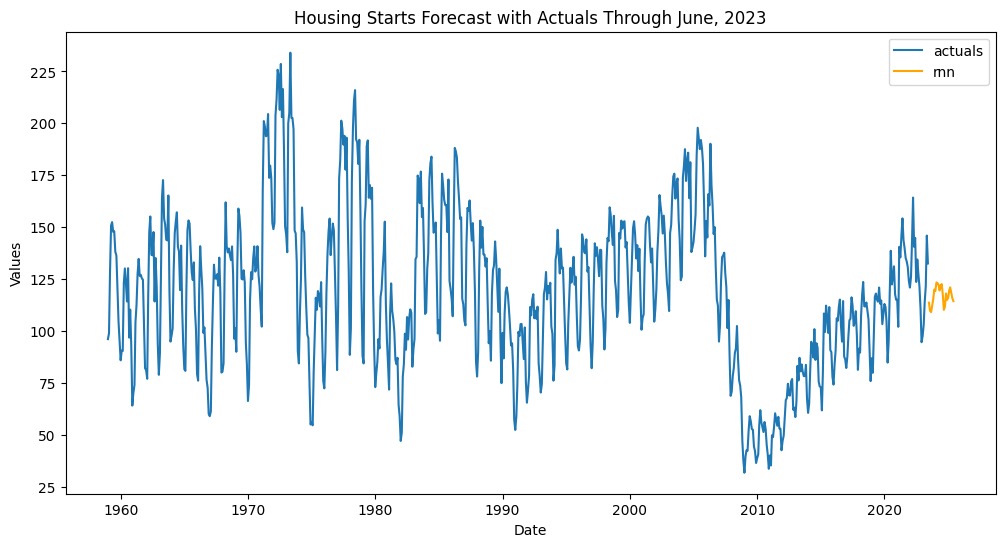

In [40]:
f_new.plot()
plt.title('Housing Starts Forecast with Actuals Through June, 2023')
plt.savefig('RNN transferred same series.png')
plt.show()

### Scenario 2: A new time series with similar characteristics

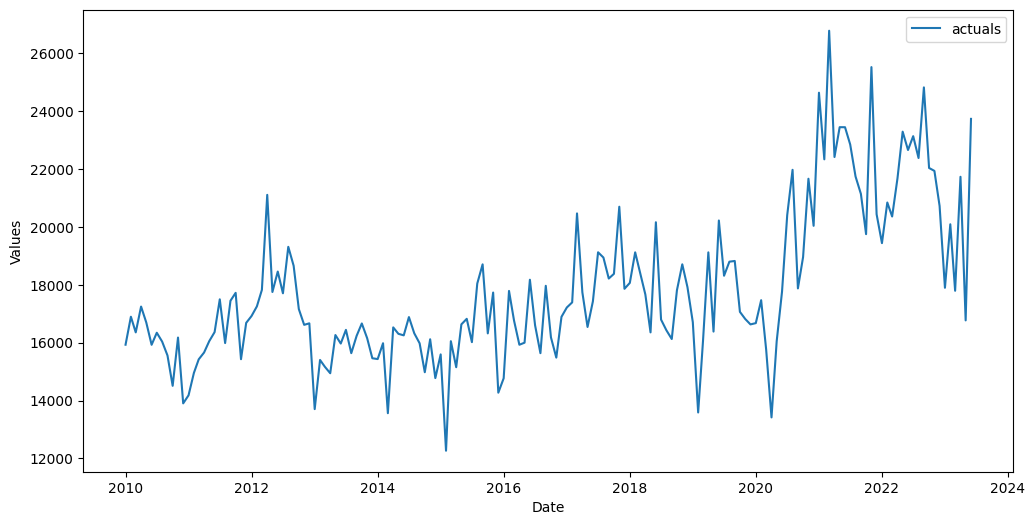

In [41]:
df = pdr.get_data_fred(
    'CANWSCNDW01STSAM',
    start = '2010-01-01',
    end = '2023-06-30',
)

f_new = Forecaster(
    y = df.iloc[:,0],
    current_dates = df.index,
    future_dates = 24, # 2-year forecast horizon
)

f_new.plot()
plt.show()

In [42]:
def transfer_forecast(f_new,transfer_from):
    f_new = infer_apply_Xvar_selection(
        infer_from=transfer_from,
        apply_to=f_new
    )
    f_new.transfer_predict(
        transfer_from=transfer_from,
        model='rnn',
        model_type='tf'
    )

In [43]:
pipeline_can = Pipeline(
    steps = [
        ('Transform',transformer),
        ('Transfer Forecast',transfer_forecast),
        ('Revert',reverter),
    ]
)

f_new = pipeline_can.fit_predict(f_new,transfer_from=f)

4/4 [==============================] - 0s 6ms/step


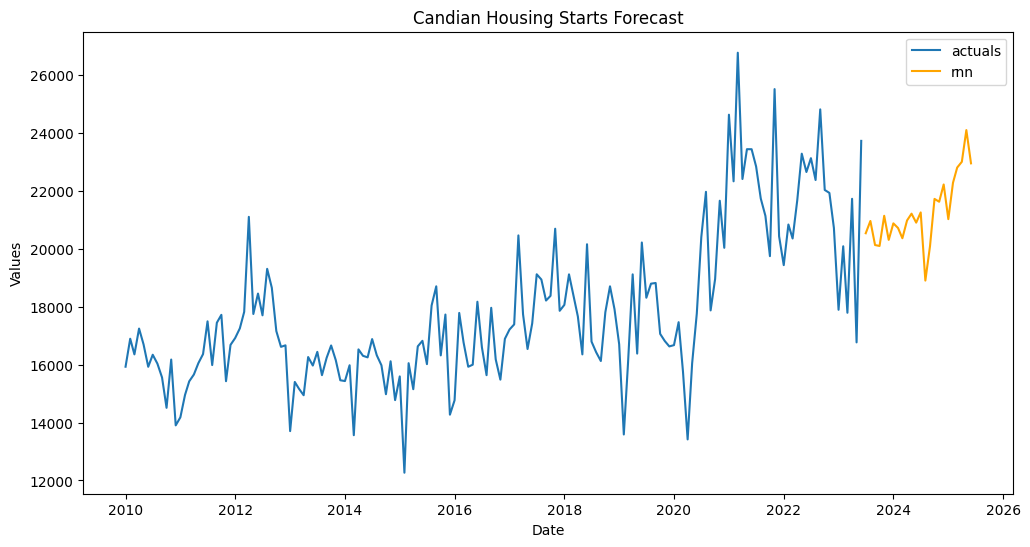

In [44]:
f_new.plot()
plt.title('Candian Housing Starts Forecast')
plt.savefig('Transferred RNN Canada')
plt.show()